In [1]:
%load_ext autoreload
%autoreload 2

In [185]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
import cv2

from tqdm.auto import tqdm


from einops import rearrange, repeat

from functools import partial

from collections import OrderedDict
import utils

In [44]:
from mzr import *

In [350]:
class MazeEnv(gym.Env):
    def __init__(self, X=15, Y=15):
        self.X, self.Y = X, Y
        self.action_space = gym.spaces.Discrete(5)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.Y, self.X))

    def set_xy(self, x, y):
        self.x, self.y = x, y

    def reset(self):
        self.x, self.y = self.X//2, self.Y//2
        obs = np.zeros((self.Y, self.X), dtype=np.float32)
        obs[self.y, self.x] = 1.
        info = {'y': self.y, 'x': self.x}
        return obs, info

    def step(self, action):
        if action==0:
            pass
        elif action==1:
            self.y -= 1
        elif action==2:
            self.y += 1
        elif action==3:
            self.x -= 1
        elif action==4:
            self.x += 1
        
        self.y = np.clip(self.y, 0, self.Y-1)
        self.x = np.clip(self.x, 0, self.X-1)

        obs = np.zeros((self.Y, self.X), dtype=np.float32)
        obs[self.y, self.x] = 1.
        info = {'y': self.y, 'x': self.x}
        reward = 0
        terminated = False
        truncated = False
        return obs, reward, terminated, truncated, info

In [351]:
def loss_fn(goal, state_latent, strategy='euclidean'):
    if strategy=='euclidean':
        return (goal-state_latent).pow(2).mean(dim=-1)
    elif strategy=='dot':
        return -torch.cosine_similarity(goal, state_latent, dim=-1)

In [682]:
class RepresentationNet(nn.Module):
    def __init__(self, env, latent_size=20):
        super().__init__()
        self.latent_size = latent_size

        self.encoder = nn.Sequential(
            layer_init(nn.Conv2d(1, 10, 3, padding=1)),
            nn.Tanh(),
            layer_init(nn.Conv2d(10, 10, 3, padding=1)),
            nn.Tanh(),
            nn.AvgPool2d(2),
            layer_init(nn.Conv2d(10, 10, 3, padding=1)),
            nn.Tanh(),
            nn.AvgPool2d(2),
            layer_init(nn.Conv2d(10, 10, 3, padding=1)),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Flatten(),
        )

        if hasattr(env, 'single_observation_space'):
            obs = env.single_observation_space.sample()
        else:
            obs = env.observation_space.sample()
        if isinstance(obs, dict):
            obs = obs['obs']
        x = torch.from_numpy(obs)[None, None]
        y = self.encoder(x)
        self.encoder.append(layer_init(nn.Linear(y.shape[-1], latent_size)))
        self.encoder.append(nn.Tanh())
        self.encoder.append(layer_init(nn.Linear(latent_size, latent_size)))

    def forward(self, obs):
        return self.encoder(obs[..., None, :, :])

In [672]:
class GCAgent(nn.Module):
    def __init__(self, env, latent_size=20, goal_size=2):
        super().__init__()
        self.rnet = RepresentationNet(env, latent_size)

        self.n_outputs = env.single_action_space.n
        self.critic = nn.Sequential(
            layer_init(nn.Linear(latent_size+goal_size, int(1.5*latent_size))),
            nn.Tanh(),
            layer_init(nn.Linear(int(1.5*latent_size), latent_size)),
            nn.Tanh(),
            layer_init(nn.Linear(latent_size, 1)),
        )
        self.actor = nn.Sequential(
            layer_init(nn.Linear(latent_size+goal_size, int(1.5*latent_size))),
            nn.Tanh(),
            layer_init(nn.Linear(int(1.5*latent_size), latent_size)),
            nn.Tanh(),
            layer_init(nn.Linear(latent_size, self.n_outputs), std=1e-5),
        )
        self.goal = None

    def get_dist_value(self, obs, goal):
        latent = self.rnet(obs)
        latent_goal = torch.cat([latent, goal], dim=-1)
        logits, value = self.actor(latent_goal), self.critic(latent_goal)
        value = rearrange(value, '... 1 -> ...')
        dist = torch.distributions.Categorical(logits=logits)
        return dist, value

    def get_value(self, obs, goal):
        dist, value = self.get_dist_value(obs, goal)
        return value

    def get_action_and_value(self, obs, goal, action=None):
        if goal is None:
            goal = self.goal
        dist, value = self.get_dist_value(obs, goal)
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), value

# Discrete Goal Space

In [357]:
class DiscreteGoalMazeEnv(gym.Wrapper):
    def __init__(self, env, goals, goal_rand_locs):
        super().__init__(env)
        self.goals = goals

        obs_space = self.observation_space
        goal_space = gym.spaces.Box(low=0, high=1, shape=self.goals.shape[1:])
        self.observation_space = gym.spaces.Dict(obs=obs_space, goal=goal_space)

        self.goal_locs = goal_rand_locs * np.array([self.env.X, self.env.Y])

    def reset(self, goal_idx=None):
        obs, info = self.env.reset()
        if goal_idx is None:
            goal_idx = np.random.choice(len(self.goals))
        self.goal_idx = goal_idx
        self.goal = self.goals[self.goal_idx]
        obs = OrderedDict(obs=obs, goal=self.goal)
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        obs = OrderedDict(obs=obs, goal=self.goal)

        distance = np.linalg.norm(self.goal_locs[self.goal_idx] - np.array([self.env.x, self.env.y]))
        reward = 1./(distance**2+1.)
        info['gx'], info['gy'] = self.goal_locs[self.goal_idx]
        info['distance'] = distance
        return obs, reward, terminated, truncated, info

In [372]:
def make_env(n_envs, goals, goal_rand_locs, max_episode_steps=20):
    def make_single_env():
        env = MazeEnv()
        env = gym.wrappers.TimeLimit(env, max_episode_steps=max_episode_steps)
        env = DiscreteGoalMazeEnv(env, goals, goal_rand_locs)
        return env
    env = gym.vector.SyncVectorEnv([make_single_env for i in range(n_envs)])
    env = utils.ToTensor(env)
    return env

In [250]:
import ppo_simple

np.random.seed(0)
torch.manual_seed(0)

def callback(i_update, data, info, **kwargs):
    if i_update%70==0:
        print(f"Update {i_update: 05d}, Start, Avg, End Reward: {data['reward'][:,  0].mean().item(): 0.5f} {data['reward'][:,  :].mean().item(): 0.5f} {data['reward'][:, -1].mean().item(): 0.5f}")
        print(info['distance'].mean())

goals = np.eye(5)
goal_rand_locs = np.random.rand(5, 2)

env = make_env(48, goals, goal_rand_locs)
agent = GCAgent(env, latent_size=10, goal_size=5)
args = ppo_simple.parse_args(env, s='--learning-rate 3e-4 --num-steps 20'.split())
# print(args)
ppo_simple.run_ppo(agent, env, args, callback)

Update  0000, Start, Avg, End Reward:  0.04913  0.06425  0.07201
6.153583244370964
Update  0070, Start, Avg, End Reward:  0.05472  0.13961  0.12125
3.611992392884988
Update  0140, Start, Avg, End Reward:  0.05496  0.21749  0.27418
2.3889504646432385
Update  0210, Start, Avg, End Reward:  0.06502  0.39144  0.50574
1.3749695743611134
Update  0280, Start, Avg, End Reward:  0.05226  0.42699  0.57424
1.0974553492358334
Update  0350, Start, Avg, End Reward:  0.05792  0.51130  0.65931
0.8225868691962992
Update  0420, Start, Avg, End Reward:  0.06547  0.57278  0.69330
0.6860817849158144
Update  0490, Start, Avg, End Reward:  0.06392  0.58269  0.75230
0.5752676010523795
Update  0560, Start, Avg, End Reward:  0.06415  0.60732  0.74644
0.5823230251856288
Update  0630, Start, Avg, End Reward:  0.05747  0.59908  0.74586
0.5837517209844342
Update  0700, Start, Avg, End Reward:  0.05740  0.61870  0.84835
0.4070807006912999
Update  0770, Start, Avg, End Reward:  0.05995  0.63315  0.83498
0.48418648168

KeyboardInterrupt: 

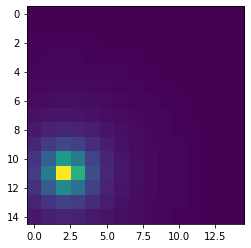

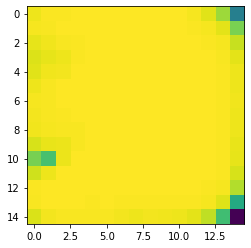

In [321]:
env = gym.vector.SyncVectorEnv([make_env for i in range(1)])
env = utils.ToTensor(env)
env0 = env.envs[0]

a = np.zeros((env0.Y, env0.X))
obs, info = env.reset()
for y in range(env0.Y):
    for x in range(env0.X):
        env.reset()
        env0.reset(0)
        env0.set_xy(x, y)
        obs, reward, _, _, _ = env.step(np.zeros(1))
        a[y, x] = reward.item()
plt.imshow(a)
plt.show()

a = np.zeros((env0.Y, env0.X))
obs, info = env.reset()
for y in range(env0.Y):
    for x in range(env0.X):
        env.reset()
        env0.reset(0)
        env0.set_xy(x, y)
        obs, reward, _, _, _ = env.step(np.zeros(1))
        value = agent.get_value(**obs)
        a[y, x] = value.item()
plt.imshow(a)
plt.show()

In [326]:
env = gym.vector.SyncVectorEnv([make_env for i in range(50)])
env = utils.ToTensor(env)

obs, info = env.reset()

for i in range(25):
    action, _, _, _ = agent.get_action_and_value(**obs)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated.any().item() or truncated.any().item():
        break

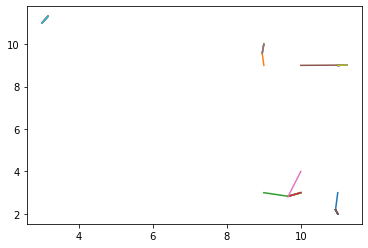

In [327]:
for i in info['final_info']:
    y, x, gy, gx = i['y'], i['x'], i['gy'], i['gx']
    plt.plot([y, gy], [x, gx])

# Learned Continuous Goal Space

In [554]:
class GoalGenerating(gym.Wrapper):
    def __init__(self, env, goal_size):
        super().__init__(env)
        self.goal_size = goal_size

        obs_space = self.observation_space
        goal_space = gym.spaces.Box(low=0, high=1, shape=(self.goal_size, ))
        self.observation_space = gym.spaces.Dict(obs=obs_space, goal=goal_space)
    
    def reset(self):
        obs, info = self.env.reset()
        self.goal = torch.randn(self.goal_size)
        obs = OrderedDict(obs=obs, goal=self.goal)
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        obs = OrderedDict(obs=obs, goal=self.goal)
        return obs, reward, terminated, truncated, info

class LatentGoalReward(gym.Wrapper):
    def __init__(self, env, rnet, loss_fn):
        super().__init__(env)
        assert isinstance(env, utils.ToTensor)
        self.rnet = rnet.to(self.env.device)
        self.loss_fn = loss_fn

        self.prev_obs = None
        self.prev_info = None

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        latent = self.rnet(obs['obs'])
        loss = self.loss_fn(obs['goal'], latent)
        reward = -loss.detach()
        info['loss'] = loss
        info['prev_obs'] = self.prev_obs
        info['prev_info'] = self.prev_info
        self.prev_obs = obs
        self.prev_info = info
        return obs, reward, terminated, truncated, info

In [513]:
# class GoalReward(gym.Wrapper):
#     def __init__(self, env, goal_size, loss_fn):
#         super().__init__(env)
#         assert isinstance(env, utils.ToTensor)
#         self.goal_size = goal_size
#         self.loss_fn = loss_fn

#         self.rnet = RepresentationNet(self.env, goal_size).to(device=self.env.device)

#         obs_space = self.observation_space
#         goal_space = gym.spaces.Box(low=0, high=1, shape=(goal_size, ))
#         self.observation_space = gym.spaces.Dict(obs=obs_space, goal=goal_space)
    
#     def reset(self):
#         obs, info = self.env.reset()
#         self.goal = torch.randn(self.env.num_envs, self.goal_size)
#         obs = OrderedDict(obs=obs, goal=self.goal)
#         return obs, info

#     def step(self, action):
#         obs, reward, terminated, truncated, info = self.env.step(action)
#         latent = self.rnet(obs)
#         loss = self.loss_fn(self.goal, latent)
#         reward = -loss.detach()
#         # info['loss'] = loss
#         obs = OrderedDict(obs=obs, goal=self.goal)
#         return obs, reward, terminated, truncated, info

In [609]:
def make_env(n_envs, rnet, strategy='euclidean', max_episode_steps=20):
    goal_size = rnet.latent_size
    def make_single_env():
        env = MazeEnv()
        env = gym.wrappers.TimeLimit(env, max_episode_steps=max_episode_steps)
        env = GoalGenerating(env, goal_size)
        return env
    env = gym.vector.SyncVectorEnv([make_single_env for i in range(n_envs)])
    env = utils.ToTensor(env)
    env = LatentGoalReward(env, rnet, loss_fn=partial(loss_fn, strategy=strategy))
    return env

In [481]:
import ppo_simple
np.random.seed(0)
torch.manual_seed(0)

def callback(i_update, data, info, **kwargs):
    if i_update%50==0:
        print(f"Update {i_update: 05d}, Start, Avg, End Reward: {data['reward'][:,  0].mean().item(): 0.5f} {data['reward'][:,  :].mean().item(): 0.5f} {data['reward'][:, -1].mean().item(): 0.5f}")
        # print(info['distance'].mean())

goal_size = 2
rnet = RepresentationNet(MazeEnv(), goal_size)
env = make_env(48, rnet, strategy='euclidean', max_episode_steps=20)
agent = GCAgent(env, latent_size=10, goal_size=goal_size)
args = ppo_simple.parse_args(env, s='--learning-rate 3e-4 --num-steps 20'.split())
# print(args)
ppo_simple.run_ppo(agent, env, args, callback)

Update  0000, Start, Avg, End Reward: -1.04160 -1.05373 -1.29291
Update  0050, Start, Avg, End Reward: -0.72830 -0.74590 -1.09168
Update  0100, Start, Avg, End Reward: -1.03515 -1.02430 -0.81560
Update  0150, Start, Avg, End Reward: -1.12891 -1.12909 -1.13190


KeyboardInterrupt: 

In [683]:
goal_size = 2
rnet = RepresentationNet(MazeEnv(), goal_size)
env = make_env(500, rnet, strategy='euclidean', max_episode_steps=20)
agent = GCAgent(env, latent_size=10, goal_size=goal_size)

opt = torch.optim.Adam(rnet.parameters(), lr=1e-4)

for i in range(0):
    obs, info = env.reset()
    for j in range(20):
        action, _, _, _ = agent.get_action_and_value(**obs)
        obs, reward, terminated, truncated, info = env.step(action)

    loss = info['prev_info']['loss'].mean()
    opt.zero_grad()
    loss.backward()
    opt.step()

    if i%10==0:
        print(loss.item())

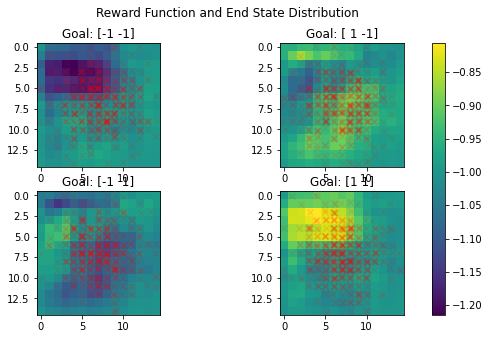

In [687]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def calc_state_reward(rnet, goal=[1., 0.], strategy='euclidean'):
    env = make_env(1, rnet, strategy=strategy, max_episode_steps=20)
    env0 = env.envs[0]
    rewards = np.zeros((env0.Y, env0.X))
    for y in range(env0.Y):
        for x in range(env0.X):
            env.reset()
            env0.goal = torch.as_tensor(goal)
            env0.set_xy(x, y)
            obs, reward, _, _, _ = env.step(np.zeros(1))
            rewards[y, x] = reward
    return rewards

def plot_end_states(agent, goal=[1., 0.]):
    env = make_env(500, rnet, strategy='euclidean', max_episode_steps=20)
    agent = GCAgent(env, latent_size=10, goal_size=goal_size)

    obs, info = env.reset()
    while True:
        action, _, _, _ = agent.get_action_and_value(**obs)
        obs, reward, terminated, truncated, info = env.step(action)
        if terminated.any() or truncated.any():
            break
    x = info['prev_info']['x']
    y = info['prev_info']['y']
    x, y = x+np.random.randn(*x.shape)*0.1, y+np.random.randn(*y.shape)*0.1
    plt.scatter(x, y, color=[1, 0, 0, .1], marker='x')

goals = np.array([[-1, -1], [1, -1], [-1, 1], [1, 1]])
# goals = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
rewards = np.stack([calc_state_reward(rnet, goal=goal, strategy='euclidean') for goal in goals])

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
cmap = cm.get_cmap('viridis')
normalizer = Normalize(rewards.min(), rewards.max())
im = cm.ScalarMappable(norm=normalizer)
for i, ax in enumerate(axs.flat):
    plt.sca(ax)
    ax.imshow(rewards[i], cmap=cmap, norm=normalizer)
    plot_end_states(agent, goal=goals[i])
    plt.title(f'Goal: {goals[i]}')
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle('Reward Function and End State Distribution')
plt.show()

In [685]:
rnet(obs['obs']).norm(dim=-1)

tensor([0.0473, 0.0225, 0.0398, 0.1201, 0.0490, 0.0583, 0.0664, 0.1232, 0.0951,
        0.0522, 0.0664, 0.0490, 0.1431, 0.0684, 0.0456, 0.1250, 0.0573, 0.0553,
        0.0516, 0.0681, 0.1201, 0.0441, 0.1260, 0.0464, 0.1232, 0.0376, 0.0951,
        0.0875, 0.0490, 0.0761, 0.0686, 0.1239, 0.0452, 0.1247, 0.0618, 0.0733,
        0.0441, 0.1250, 0.0532, 0.1201, 0.0476, 0.0951, 0.0686, 0.0402, 0.0700,
        0.0456, 0.0714, 0.0951, 0.0625, 0.0490, 0.0398, 0.0573, 0.0892, 0.0675,
        0.0553, 0.0581, 0.0334, 0.0447, 0.1260, 0.0686, 0.0681, 0.0567, 0.0955,
        0.0398, 0.0525, 0.0681, 0.0843, 0.0892, 0.1263, 0.1192, 0.0490, 0.1019,
        0.0525, 0.0486, 0.0675, 0.0452, 0.0686, 0.0686, 0.0843, 0.0733, 0.0843,
        0.1141, 0.0334, 0.1232, 0.0525, 0.0525, 0.0536, 0.0334, 0.0402, 0.0525,
        0.0516, 0.0464, 0.0615, 0.0376, 0.0536, 0.0402, 0.0761, 0.0583, 0.0217,
        0.0686, 0.0955, 0.0536, 0.1217, 0.0951, 0.0664, 0.0532, 0.0394, 0.0391,
        0.0464, 0.0664, 0.0447, 0.0532, 

In [509]:
def show_behavior(agent, rnet, goal, n_steps=20, n_envs=1000):
    env = gym.vector.SyncVectorEnv([MazeEnv for i in range(n_envs)])
    # env = gym.wrappers.TimeLimit(env, max_episode_steps=20)
    env = ToTensorWrapper(env, device=None, dtype=torch.float32)
    env = MyRewardWrapper(env, rnet, loss_fn=partial(loss_fn, strategy='dot'))
    env.set_goal(goal)
    env0 = env.envs[0]

    rewards = []
    pos = []
    obs, info = env.reset()
    for i in tqdm(range(n_steps)):
        with torch.no_grad():
            action, log_prob, entropy, values = agent.get_action_and_value(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        x, y = info['x'], info['y']
        pos.append([x, y])
    pos = np.array(pos)
    pos = np.moveaxis(pos, 0, 1)

    print(f'Cumulative Reward: {torch.stack(rewards).mean(dim=-1).sum().item():.4f}')
    print(f' Mean Mean Reward: {torch.stack(rewards).mean(dim=-1).mean().item():.4f}')
    print(f'      Mean Reward: {torch.stack(rewards).mean().item():.4f}')
    print(f'       End Reward: {reward.mean(dim=-1).item():.4f}')


    r = np.random.randn(*pos.shape)
    a = pos + 3e-1*r
    c = np.arange(pos.shape[1])
    c = np.tile(c[:, None], (1, pos.shape[2]))
    a = a.reshape(2, -1)
    c = c.reshape(-1)

    plt.figure(figsize=(12, 4))
    plt.subplot(122)
    plt.scatter(*a, c=c)
    plt.colorbar()
    plt.title('Location vs Trajectory Time')
    plt.xlim(0, env0.X)
    plt.ylim(env0.Y, 0)

    env.reset()
    A = np.zeros((env0.X, env0.Y, n_envs))
    _, reward, _, _, _ = env0.step(0)
    for x in tqdm(range(env0.X)):
        for y in range(env0.Y):
            for envi in env.envs:
                envi.set_xy(x, y)
            _, reward, _, _, _ = env.step(np.zeros(n_envs))
            A[y, x, :] = reward.tolist()

    plt.subplot(121)
    plt.imshow(A.mean(axis=-1))
    plt.title('Reward Function')
    plt.colorbar()
    plt.show()

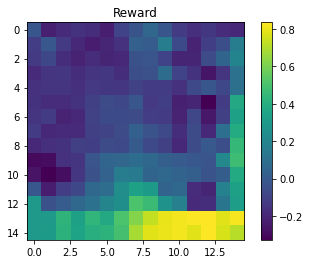

In [510]:
torch.manual_seed(9)
latent_size = 2

env = gym.vector.SyncVectorEnv([MazeEnv for i in range(1)])
# env = gym.wrappers.TimeLimit(env, max_episode_steps=20)
env = ToTensorWrapper(env, device=None, dtype=torch.float32)

rnet = RepresentationNet(env, latent_size=latent_size)
goal = torch.randn(1, latent_size)

env = MyRewardWrapper(env, rnet, loss_fn=partial(loss_fn, strategy='dot'))
env.set_goal(goal)

env0 = env.envs[0]

A = np.zeros((env0.Y, env0.X))
for x in range(env0.X):
    for y in range(env0.Y):
        env.reset()
        for envi in env.envs:
            envi.set_xy(x, y)
        obs, reward, _, _, _ = env.step(np.zeros(1))
        latent = rnet(obs)
        loss = loss_fn(goal, latent, strategy='dot')
        assert torch.allclose(reward, -loss) # sanity check
        A[y, x] = reward.mean().item()

plt.title('Reward')
plt.imshow(A)
plt.colorbar()

In [455]:
env = gym.vector.SyncVectorEnv([MazeEnv for i in range(100)])
env = ToTensorWrapper(env, device=None, dtype=torch.float32)
env = MyRewardWrapper(env, rnet, loss_fn=partial(loss_fn, strategy='dot'))
env.set_goal(goal)

obs, info = env.reset()
obs, reward, terminated, truncated, info = env.step(np.zeros(100))
print(obs.shape, reward.shape, terminated.shape, truncated.shape, info.keys())

print(f'Center reward: {A[7, 7]}')
print(f'  Mean reward: {A.mean()}')
print(f'   Min reward: {A.min()}')
print(f'   Max reward: {A.max()}')

# rnet
agent = GCPolicy(env, latent_size=10, rnet=None)
agent.set_goal(repeat(goal, '1 n -> e n', e=100))
action, log_prob, entropy, values = agent.get_action_and_value(torch.from_numpy(env.observation_space.sample()))

torch.Size([100, 15, 15]) torch.Size([100]) torch.Size([100]) torch.Size([100]) dict_keys(['y', '_y', 'x', '_x', 'loss'])
Center reward: 0.030511975288391113
  Mean reward: 0.0355209928088718
   Min reward: -0.32744014263153076
   Max reward: 0.8359813094139099


100%|██████████| 20/20 [00:00<00:00, 69.59it/s]


Cumulative Reward: -1.0521
 Mean Mean Reward: -0.0526
      Mean Reward: -0.0526
       End Reward: -0.0502


100%|██████████| 15/15 [00:01<00:00,  9.93it/s]


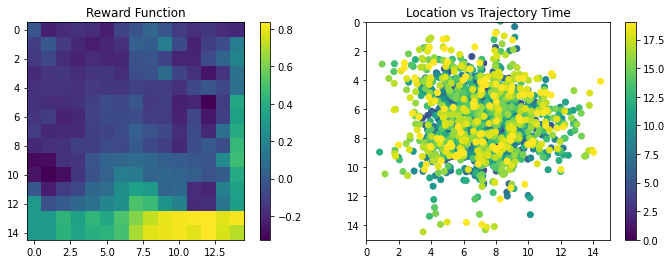

In [456]:
show_behavior(agent, rnet, goal, n_envs=100)

In [457]:
r = []
obs, info = env.reset()
for i_step in range(20):
    with torch.no_grad():
        action, logprob, entropy, value = agent.get_action_and_value(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    r.append(reward)
r = torch.stack(r)
print(r.mean())

tensor(-0.0284)


Namespace(exp_name='ppo_simple', seed=1, torch_deterministic=True, cuda=True, track=False, wandb_project_name='cleanRL', wandb_entity=None, capture_video=False, total_timesteps=10000000, learning_rate=0.0003, num_steps=20, anneal_lr=True, gamma=0.99, gae_lambda=0.95, num_minibatches=4, update_epochs=4, norm_adv=True, clip_coef=0.1, clip_vloss=True, ent_coef=0.01, vf_coef=0.5, max_grad_norm=0.5, target_kl=None, num_envs=100, batch_size=2000, minibatch_size=500)
00001: -0.0462
00002: -0.0302
00003: -0.0428
00004: -0.0256
00005: -0.0339
00006: 0.0079
00007: 0.0411
00008: 0.0891
00009: 0.1588
00030: 0.5464
00060: 0.5915
00090: 0.5862


100%|██████████| 20/20 [00:00<00:00, 86.80it/s]


Cumulative Reward: 11.8024
 Mean Mean Reward: 0.5901
      Mean Reward: 0.5901
       End Reward: 0.7617


100%|██████████| 15/15 [00:01<00:00,  9.17it/s]


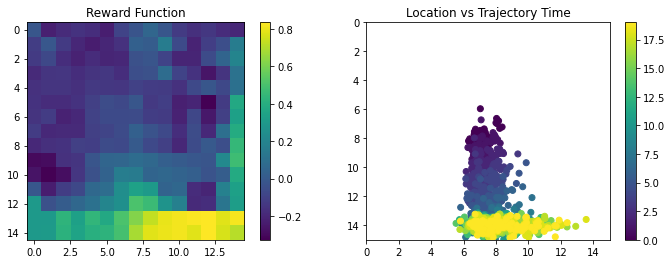

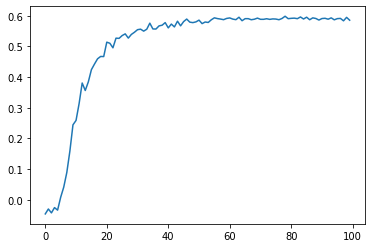

KeyboardInterrupt: 

In [458]:
import ppo
import ppo_simple

rewards = []
def callback_fn(update, **kwargs):
    if update<10 or update%30==0:
        print(f'{update:05d}: {kwargs["rewards"].mean().item():.4f}')
    rewards.append(kwargs['rewards'].mean().item())

    if update%100==0:
        show_behavior(agent, rnet, goal, n_envs=100)
        plt.plot(rewards)
        plt.show()

args = ppo_simple.parse_args(env, s='--learning-rate 3e-4 --num-steps 20'.split())
print(args)
ppo_simple.run_ppo_simple(agent, env, args, callback_fn=callback_fn)

100%|██████████| 20/20 [00:00<00:00, 48.98it/s]


Cumulative Reward: 11.8022
 Mean Mean Reward: 0.5901
      Mean Reward: 0.5901
       End Reward: 0.7831


100%|██████████| 15/15 [00:01<00:00,  9.03it/s]


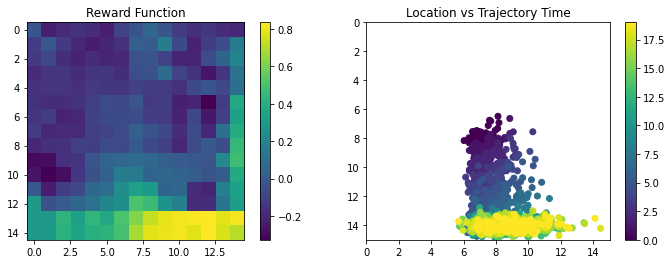

In [460]:
show_behavior(agent, rnet, goal, n_envs=100)

In [461]:
r = []
obs, info = env.reset()
for i_step in range(20):
    with torch.no_grad():
        action, logprob, entropy, value = agent.get_action_and_value(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    r.append(reward)
r = torch.stack(r)
print(r.mean())

tensor(0.5928)


# Full code

In [553]:
n_envs = 100
latent_size = 2
latent_size_agent = 10

env = gym.vector.SyncVectorEnv([MazeEnv for i in range(n_envs)])
env = ToTensorWrapper(env, device=None, dtype=torch.float32)
env = MyRewardWrapper(env, rnet, loss_fn=partial(loss_fn, strategy='dot'))

agent = GCPolicy(env, latent_size=latent_size_agent, rnet=None)
rnet = RepresentationNet(env, latent_size=latent_size)

# goal_list = torch.eye(latent_size)
goal_list = torch.randn(10, latent_size)
goal = goal_list[torch.randint(0, len(goal_list), (n_envs,))]
env.set_goal(goal)
agent.set_goal(goal)

obs, info = env.reset()
action, log_prob, entropy, values = agent.get_action_and_value(obs)
obs, reward, terminated, truncated, info = env.step(action.tolist())
print(obs.shape, reward.shape, terminated.shape, truncated.shape, info.keys())
obs, info = env.reset()

torch.Size([100, 15, 15]) torch.Size([100]) torch.Size([100]) torch.Size([100]) dict_keys(['y', '_y', 'x', '_x', 'loss'])


Namespace(exp_name='ppo_simple', seed=1, torch_deterministic=True, cuda=True, track=False, wandb_project_name='cleanRL', wandb_entity=None, capture_video=False, total_timesteps=10000000, learning_rate=0.0003, num_steps=20, anneal_lr=True, gamma=0.99, gae_lambda=0.95, num_minibatches=4, update_epochs=4, norm_adv=True, clip_coef=0.1, clip_vloss=True, ent_coef=0.01, vf_coef=0.5, max_grad_norm=0.5, target_kl=None, num_envs=100, batch_size=2000, minibatch_size=500)
00001: -0.0797
00002: -0.0247
00003: -0.0060
00004: -0.0066
00005: 0.1246
00006: 0.0803
00007: -0.0630
00008: -0.0184
00009: 0.0558
00030: 0.2222
00060: 0.4208
00090: 0.4132


100%|██████████| 20/20 [00:00<00:00, 87.03it/s]


Cumulative Reward: 1.9177
 Mean Mean Reward: 0.0959
      Mean Reward: 0.0959
       End Reward: 0.0600


100%|██████████| 15/15 [00:01<00:00,  9.92it/s]


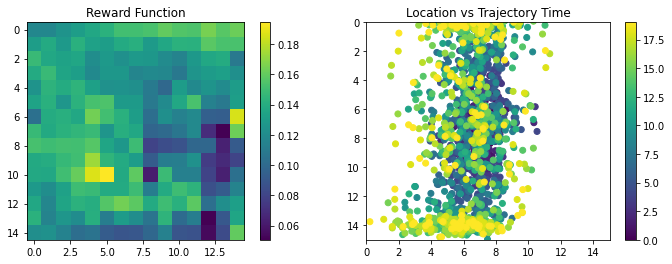

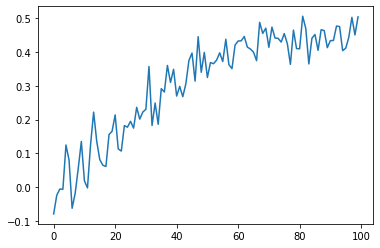

00120: 0.4854
00150: 0.5535
00180: 0.4963


100%|██████████| 20/20 [00:00<00:00, 90.08it/s]


Cumulative Reward: -0.3563
 Mean Mean Reward: -0.0178
      Mean Reward: -0.0178
       End Reward: -0.0716


100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


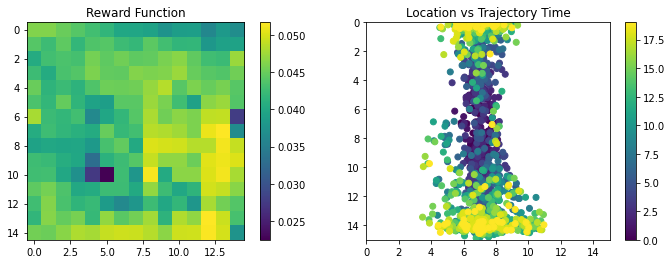

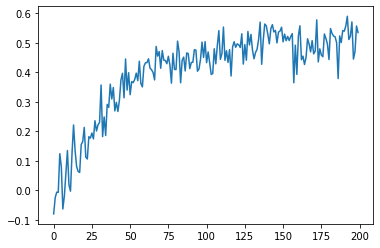

00210: 0.4654
00240: 0.5165
00270: 0.4659
00300: 0.5757


100%|██████████| 20/20 [00:00<00:00, 71.94it/s]


Cumulative Reward: 2.9520
 Mean Mean Reward: 0.1476
      Mean Reward: 0.1476
       End Reward: 0.1142


100%|██████████| 15/15 [00:01<00:00,  8.06it/s]


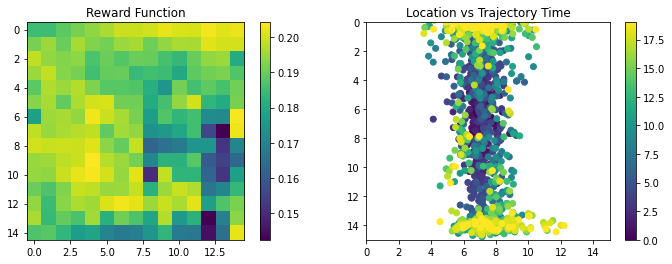

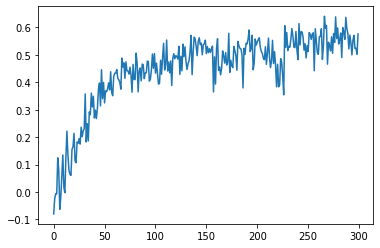

KeyboardInterrupt: 

In [554]:
import ppo_simple

rewards = []
def callback_fn(update, **kwargs):
    goal = goal_list[torch.randint(0, len(goal_list), (n_envs,))]
    env.set_goal(goal)
    agent.set_goal(goal)

    if update<10 or update%30==0:
        print(f'{update:05d}: {kwargs["rewards"].mean().item():.4f}')
    rewards.append(kwargs['rewards'].mean().item())

    if update%100==0:
        show_behavior(agent, rnet, goal, n_envs=100)
        plt.plot(rewards)
        plt.show()

args = ppo_simple.parse_args(env, s='--learning-rate 3e-4 --num-steps 20'.split())
print(args)
ppo_simple.run_ppo_simple(agent, env, args, callback_fn=callback_fn)

tensor([-0.9718, -1.3435])


100%|██████████| 20/20 [00:00<00:00, 49.15it/s]


Cumulative Reward: 8.4299
      Mean Reward: 0.4215
       End Reward: 0.3392


100%|██████████| 15/15 [00:02<00:00,  6.90it/s]


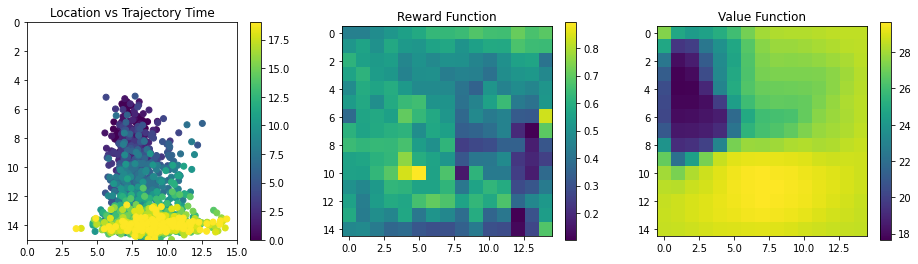

tensor([-0.0736,  0.7532])


100%|██████████| 20/20 [00:00<00:00, 72.04it/s]


Cumulative Reward: 1.7967
      Mean Reward: 0.0898
       End Reward: 0.0423


100%|██████████| 15/15 [00:02<00:00,  6.87it/s]


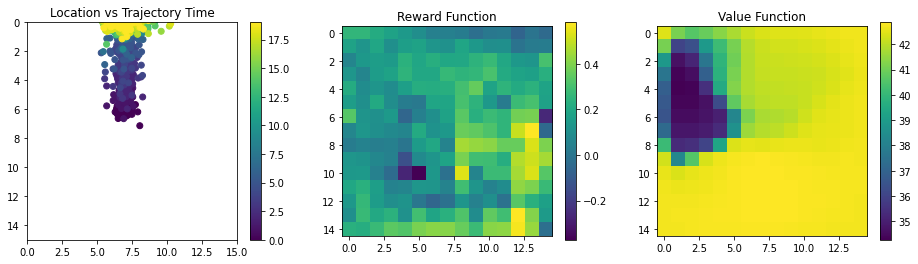

tensor([ 0.4899, -0.0361])


100%|██████████| 20/20 [00:00<00:00, 54.30it/s]


Cumulative Reward: -19.7502
      Mean Reward: -0.9875
       End Reward: -0.9865


100%|██████████| 15/15 [00:02<00:00,  6.06it/s]


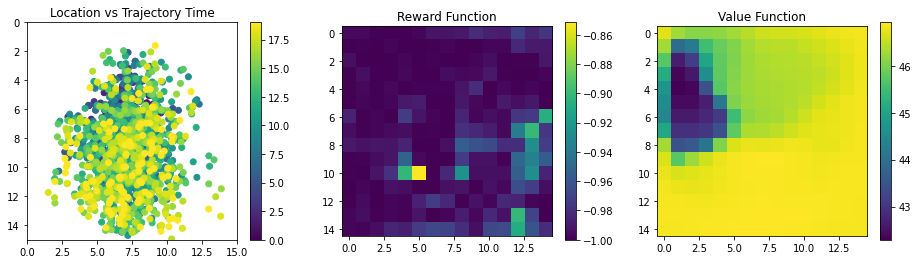

tensor([ 0.6514, -1.6297])


100%|██████████| 20/20 [00:00<00:00, 71.35it/s]


Cumulative Reward: -11.1019
      Mean Reward: -0.5551
       End Reward: -0.6373


100%|██████████| 15/15 [00:02<00:00,  7.19it/s]


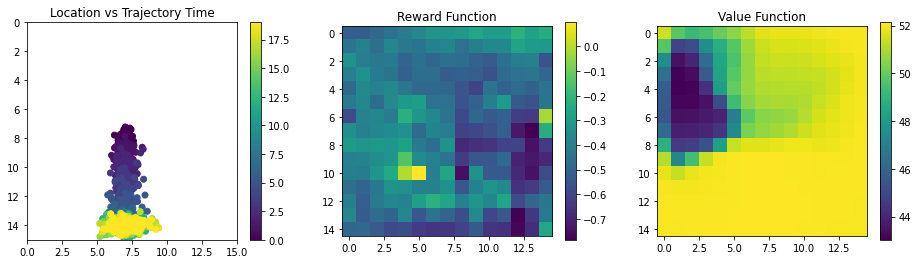

tensor([-0.4198,  0.2770])


100%|██████████| 20/20 [00:00<00:00, 83.28it/s]


Cumulative Reward: 16.5641
      Mean Reward: 0.8282
       End Reward: 0.8009


100%|██████████| 15/15 [00:02<00:00,  7.19it/s]


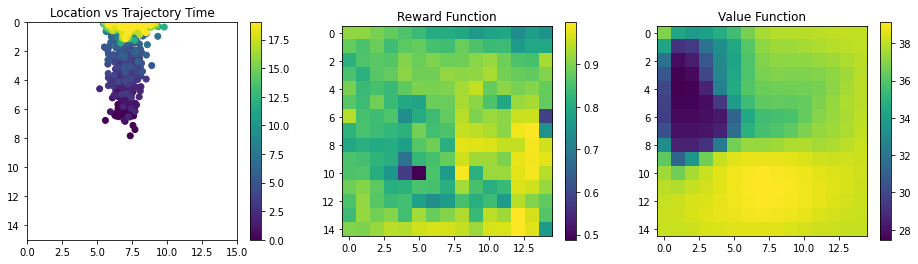

tensor([-0.5195, -0.3095])


100%|██████████| 20/20 [00:00<00:00, 77.09it/s]


Cumulative Reward: 16.9315
      Mean Reward: 0.8466
       End Reward: 0.8882


100%|██████████| 15/15 [00:02<00:00,  7.18it/s]


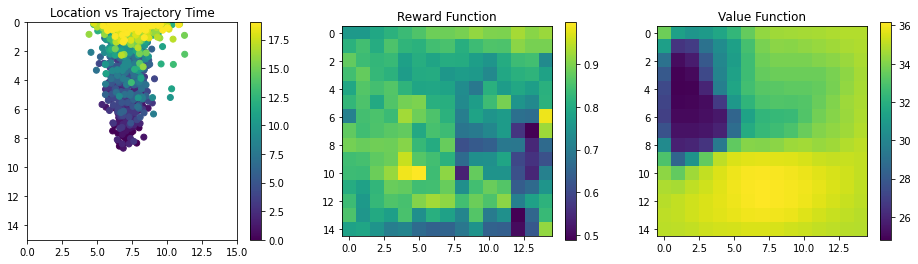

tensor([ 1.1356, -0.9743])


100%|██████████| 20/20 [00:00<00:00, 78.27it/s]


Cumulative Reward: -17.3665
      Mean Reward: -0.8683
       End Reward: -0.9202


100%|██████████| 15/15 [00:02<00:00,  7.14it/s]


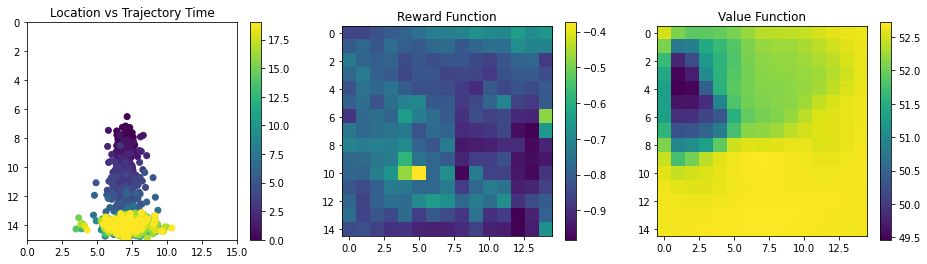

tensor([1.2820, 1.0769])


100%|██████████| 20/20 [00:00<00:00, 73.73it/s]


Cumulative Reward: -14.5036
      Mean Reward: -0.7252
       End Reward: -0.7611


100%|██████████| 15/15 [00:02<00:00,  5.75it/s]


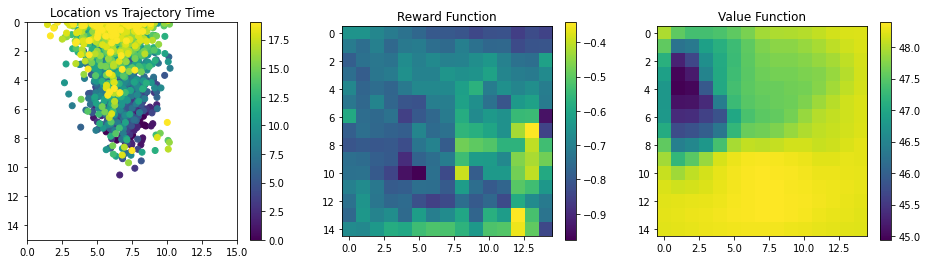

tensor([-0.1607,  0.5283])


100%|██████████| 20/20 [00:00<00:00, 66.12it/s]


Cumulative Reward: 5.6596
      Mean Reward: 0.2830
       End Reward: 0.2380


100%|██████████| 15/15 [00:02<00:00,  7.09it/s]


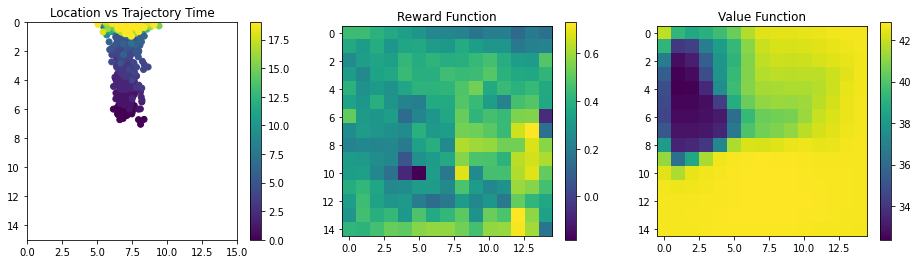

tensor([-1.9052, -0.6562])


100%|██████████| 20/20 [00:00<00:00, 63.48it/s]


Cumulative Reward: 18.8170
      Mean Reward: 0.9408
       End Reward: 0.9651


100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


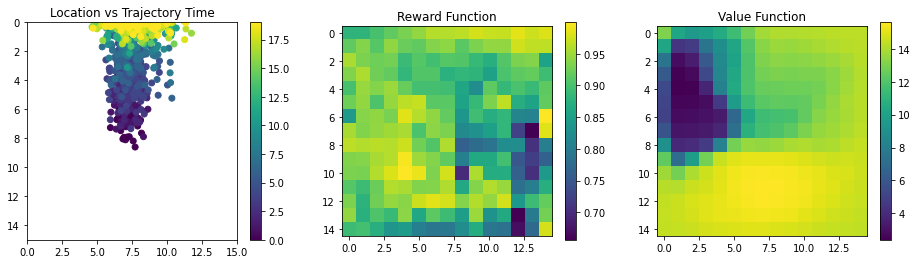

In [564]:
def show_goals(goal_list, rnet, agent, n_envs=100, n_steps=20):
    for goal in goal_list:
        goal = repeat(goal, 'n -> e n', e=n_envs)
        env = gym.vector.SyncVectorEnv([MazeEnv for i in range(n_envs)])
        env = ToTensorWrapper(env, device=None, dtype=torch.float32)
        env = MyRewardWrapper(env, rnet, loss_fn=partial(loss_fn, strategy='dot'))
        env0 = env.envs[0]

        env.set_goal(goal)
        agent.set_goal(goal)
        print(goal[0])

        rewards = torch.zeros(n_envs, n_steps)
        pos = []
        obs, info = env.reset()
        for i in tqdm(range(n_steps)):
            with torch.no_grad():
                action, log_prob, entropy, values = agent.get_action_and_value(obs)
            obs, rewards[:, i], terminated, truncated, info = env.step(action)
            pos.append([info['x'], info['y']])
        pos = np.array(pos)
        pos = np.moveaxis(pos, 0, 1)

        print(f'Cumulative Reward: {rewards.sum(dim=-1).mean(dim=0).item():.4f}')
        print(f'      Mean Reward: {rewards.mean().item():.4f}')
        print(f'       End Reward: {rewards[:, -1].mean(dim=-1).item():.4f}')

        r = np.random.randn(*pos.shape)
        a = pos + 3e-1*r
        c = np.arange(pos.shape[1])
        c = np.tile(c[:, None], (1, pos.shape[2]))
        a = a.reshape(2, -1)
        c = c.reshape(-1)

        plt.figure(figsize=(16, 4))
        plt.subplot(131)
        plt.scatter(*a, c=c)
        plt.colorbar()
        plt.title('Location vs Trajectory Time')
        plt.xlim(0, env0.X)
        plt.ylim(env0.Y, 0)

        env.reset()
        reward_map = np.zeros((env0.X, env0.Y, n_envs))
        for x in tqdm(range(env0.X)):
            for y in range(env0.Y):
                for envi in env.envs:
                    envi.set_xy(x, y)
                _, reward, _, _, _ = env.step(np.zeros(n_envs))
                reward_map[y, x, :] = reward.tolist()

        plt.subplot(132)
        plt.imshow(reward_map.mean(axis=-1))
        plt.title('Reward Function')
        plt.colorbar()

        env.reset()
        value_map = np.zeros((env0.X, env0.Y, n_envs))
        for x in tqdm(range(env0.X)):
            for y in range(env0.Y):
                for envi in env.envs:
                    envi.set_xy(x, y)
                obs, reward, _, _, _ = env.step(np.zeros(n_envs))
                value = agent.get_value(obs)
                value_map[y, x, :] = value.tolist()

        plt.subplot(133)
        plt.imshow(value_map.mean(axis=-1))
        plt.title('Value Function')
        plt.colorbar()

        plt.show()

show_goals(goal_list, rnet, agent)

In [462]:
import ppo

torch.manual_seed(0)
goal = torch.randn(100, 10)

env = gym.vector.SyncVectorEnv([MazeEnv for i in range(100)])
env = ToTensorWrapper(env, device=None, dtype=torch.float32)
env = MyRewardWrapper(env, rnet, loss_fn=partial(loss_fn, strategy='dot'))
env.set_goal(goal)

rnet = RepresentationNet(env, latent_size=10)
policy = GCPolicy(env, latent_size=10, rnet=None)
policy.set_goal(goal)

opt = torch.optim.Adam(rnet.parameters(), lr=1e-3)

def update_rnet():
    pass

def callback_fn(i_step, **kwargs):
    # goal = torch.randn(100, 10)
    # env.set_goal(goal)
    # policy.set_goal(goal)
    # print(kwargs['obs'].shape)
    print(f'{i_step:05d}: {kwargs["rewards"].mean().item():.4f}')

args = ppo.parse_args(env, s=None)
ppo.run_ppo(policy, env, args, callback_fn=callback_fn)

00001: 0.0210
00002: 0.0448
00003: 0.0564
00004: 0.0516
00005: 0.0566
00006: 0.0644
00007: 0.0728
00008: 0.0681
00009: 0.0663
00010: 0.0674
00011: 0.0639
00012: 0.0674
00013: 0.0623
00014: 0.0682
00015: 0.0671
00016: 0.0706
00017: 0.0665
00018: 0.0669
00019: 0.0701
00020: 0.0678
00021: 0.0656
00022: 0.0686
00023: 0.0674
00024: 0.0674
00025: 0.0667
00026: 0.0714
00027: 0.0815
00028: 0.0713
00029: 0.0766
00030: 0.0808
00031: 0.0733
00032: 0.0745
00033: 0.0699
00034: 0.0683


KeyboardInterrupt: 

In [446]:
policy.goal.shape

torch.Size([100, 10])

In [601]:
env = gym.make('MontezumaRevenge-v4', frameskip=1)
env = gym.wrappers.AtariPreprocessing(env)

obs, info = env.reset()
print(obs.shape, info)
for i in range(10):
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
    print(obs.shape, reward, terminated, truncated, info)

A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]


(84, 84) {'lives': 6, 'episode_frame_number': 8, 'frame_number': 8}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 12, 'frame_number': 12}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 16, 'frame_number': 16}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 20, 'frame_number': 20}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 24, 'frame_number': 24}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 28, 'frame_number': 28}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 32, 'frame_number': 32}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 36, 'frame_number': 36}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 40, 'frame_number': 40}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 44, 'frame_number': 44}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 48, 'frame_number': 48}


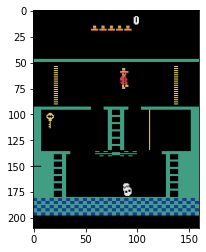

In [127]:
plt.imshow(obs)

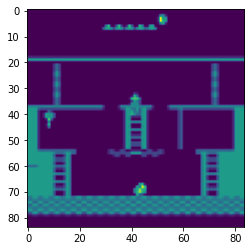

In [125]:
plt.imshow(obs)

In [131]:
from functools import partial

def make_env(env_id, seed, idx, capture_video, run_name):
    env = gym.make(env_id, frameskip=1)
    env = gym.wrappers.AtariPreprocessing(env)
    if capture_video:
        if idx == 0:
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env

env_id = 'MontezumaRevenge-v4'
n_envs = 10

envs = gym.vector.SyncVectorEnv(
    [partial(make_env, env_id=env_id, seed=i, idx=i, capture_video=False, run_name='run_name') for i in range(n_envs)]
)


In [147]:
obs, info = envs.reset()

obs, reward, terminated, truncated, info = envs.step(envs.action_space.sample())
obs.shape, reward.shape, terminated.shape, truncated.shape, info.keys()

((10, 84, 84),
 (10,),
 (10,),
 (10,),
 dict_keys(['lives', '_lives', 'episode_frame_number', '_episode_frame_number', 'frame_number', '_frame_number']))

In [142]:
info

{'lives': array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6]),
 '_lives': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 'episode_frame_number': array([ 7, 17, 30, 34, 11, 19, 19, 13, 12, 31]),
 '_episode_frame_number': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 'frame_number': array([113, 111, 145, 139,  94, 141, 138, 107,  93, 153]),
 '_frame_number': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True])}

In [ ]:
batch_size = 32
latent_size = 2
env = MZRevenge(n_envs=batch_size)

rnet = RepresentationNet(env, latent_size)
policy = GCPolicy(env, latent_size, rnet=None) # keep separate rnet

opt = torch.optim.Adam(rnet.parameters(), lr=5e-4)


losses = []
pbar = tqdm(range(100))
for i in pbar:
    goal = torch.randn(batch_size, latent_size)

    _, obs, reward, done, info = env.reset()
    o = []
    for i in range(50):
        action, log_prob, entropy, values = policy.get_action_and_value(obs, goal)
        _, obs, reward, done, info = env.step(action.tolist())
        o.append(obs)
    o = torch.stack(o, dim=1)
    # o = o[:, -1]
    # print(o.shape)

    o_flat = rearrange(o, 'g t c h w -> (g t) c h w')
    latent = rnet(o_flat)
    latent = rearrange(latent, '(g t) l -> g t l', g=len(goal))
    # print(goal.shape, latent.shape)
    loss = loss_fn(goal[:, None, :], latent).mean()
    loss.backward()

    if i%10==0:
        opt.step()
        opt.zero_grad()

    losses.append(loss.item())
    pbar.set_postfix(loss=loss.item())

In [ ]:

batch_size = 32
latent_size = 2
env = MZRevenge(n_envs=batch_size)

rnet = RepresentationNet(env, latent_size)
policy1 = GCPolicy(env, latent_size, rnet=None) # keep separate rnet
policy2 = GCPolicy(env, latent_size, rnet=None) # keep separate rnet

_, obs, reward, done, info = env.reset()
o = []
for i in tqdm(range(50)):
    action, log_prob, entropy, values = policy1.get_action_and_value(obs, goal)
    _, obs, reward, done, info = env.step(action.tolist())
    o.append(obs)
o = torch.stack(o, dim=1)



In [307]:
def calc_gae(rewards, values, gamma=0.99, gae_lambda=0.95):
    """
    Generalized Advantage Estimation
    rewards, values should have shape (n_trajs, len_traj)
    Return value:
     - advantages, returns of shape (n_trajs, len_traj-1)
    """
    n_trajs, len_traj = rewards.shape
    t = torch.arange(len_traj).expand(n_trajs, -1)

    values_now, values_next = values[..., :-1], values[..., 1:]
    rewards_now, rewards_next = rewards[..., :-1], rewards[..., 1:]
    t_now, t_next = t[..., :-1], t[..., 1:]

    # Compute temporal difference residual (TDR)
    # shape: (n_trajs, len_traj-1)
    tdr_now = (rewards_now + gamma*values_next) - values_now
    def reverse_cumsum(x, dim=0): # cumsum from the end
        return x + x.sum(dim=dim, keepdims=True) - torch.cumsum(x, dim=dim)

    # advantages = ((gamma*gae_lambda)**t_now) * tdr_now
    # advantages = reverse_cumsum(advantages, dim=-1)

    advantages = torch.zeros_like(tdr_now)
    for i in range(0, len_traj-1):
        l = torch.arange(0, len_traj-1-i)
        advantages[:, i] = (((gamma*gae_lambda)**l) * tdr_now[:, i:]).sum(dim=-1)

    # adv = torch.zeros_like(tdr_now)
    # for i in range(0, len_traj-1):
    #     for l in range(0, len_traj-1):
    #         if i+l>=len_traj-1:
    #             break
    #         adv[:, i] += (gamma*gae_lambda)**(l) * tdr_now[:, i+l]
        
    returns = advantages + values_now
    return advantages, returns

def calc_manual_gae(rewards, values, gamma=0.99, gae_lambda=0.95):
    """
    Generalized Advantage Estimation
    rewards, values should have shape (n_trajs, len_traj)
    Return value:
     - advantages, returns of shape (n_trajs, len_traj-1)
    """
    n_trajs, len_traj = rewards.shape
    t = torch.arange(len_traj).expand(n_trajs, -1)

    values_now, values_next = values[..., :-1], values[..., 1:]
    rewards_now, rewards_next = rewards[..., :-1], rewards[..., 1:]
    t_now, t_next = t[..., :-1], t[..., 1:]

    # Compute temporal difference residual (TDR)
    # shape: (n_trajs, len_traj-1)
    tdr_now = (rewards_now + gamma*values_next) - values_now

    adv = torch.zeros_like(tdr_now)
    for i in range(0, len_traj-1):
        for l in range(0, len_traj-1):
            if i+l>=len_traj-1:
                break
            adv[:, i] += (gamma*gae_lambda)**(l) * tdr_now[:, i+l]
    # return tdr_now, _
    return adv, None

torch.manual_seed(0)
rewards = torch.randn(100, 21)
values = torch.randn(100, 21)

a, _ = calc_gae(rewards, values)
b, _ = calc_manual_gae(rewards, values)

print(torch.allclose(a, b))

False
